# Applied data analysis P4 a)

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from numpy import interp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from collections import Counter
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

### Prepare the data of each regression method

In [2]:
#read the data
data = pd.read_csv('CivilWarOnset/SambnisImp.csv')

### When loading the data for replication purposes, note that the authors only load the following 91 variables:

In [3]:
df = data[["ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

#Take the variables that were used in each logistic regression method
# Model 1: Fearon and Laitin (2003):

df_FearonLaitin = data[["warhist", "ln_gdpen", "lpopns", "lmtnest", "ncontig", "oil", "nwstate", "inst3", "pol4", "ef", "relfrac"]]

# Model 2: Collier and Hoeffler (2004):
df_CollierHoeffler = data[["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth", "warhist", "lmtnest", "ef", "popdense", "lpopns", "coldwar", "seceduc", "ptime"]]

# Model 3: Hegre and Sambanis (2006):
df_HegreSambanis = data[["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]]

#Dependent variable Y, binary measure of whether a civil war onset occurred for a given country, i, in a given year j.
dep_var = data['warstds']

### Data correction

### Logistic regression function
This function does the logistic regression and calculate the True and False positive rate with a 10-fold cross-validation. The idea is to get the true positive rate for each fold and calculate the mean of it to get the 10-fold cross-validation.

In [4]:
def roc_10fold_crossvalidation(X, y, classifier, sampling=None):

    #Kfold will split the data in 10 folds
    kf = KFold(n_splits=10)
    #create a linespace to interpolate the positive rate with it (it will smoothe the curve)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    #Loop that iterates over each folds
    for train, test in kf.split(X):
        
        #Uses 9 filds for the training data and 1 fold for the test data 
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        if sampling:
            model = make_pipeline_imb(sampling(),classifier)
            model.fit(X_train, y_train)
        else:
            model = classifier
            model.fit(X_train, y_train)

        # Predict the probabilities
        probs = model.predict_proba(X_test)

        # Keep only positive probabilities outcome
        probs = probs[:, 1]

        # Calculate roc 
        fpr, tpr, _ = roc_curve(y_test, probs)
        
        # Do the interpolation with positive rates
        tprs.append(interp(mean_fpr, fpr, tpr)) 
        tprs[-1][0] = 0.0



    # Make the mean of the true positive rates
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    return (mean_fpr, mean_tpr)

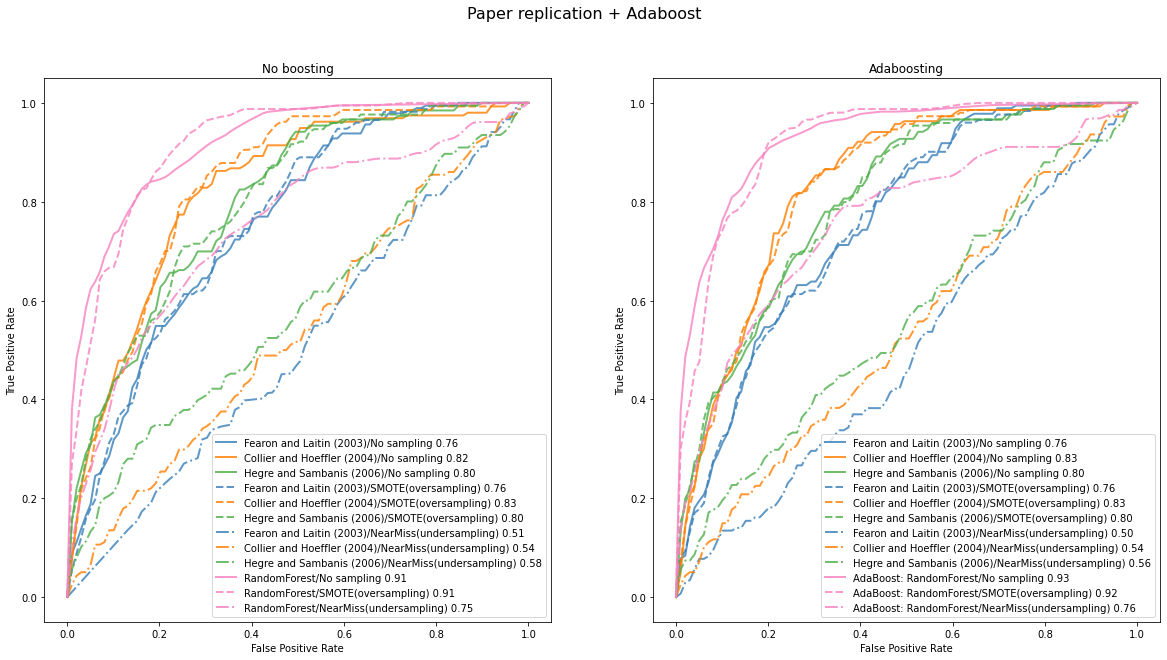

In [18]:
### Plotting the results

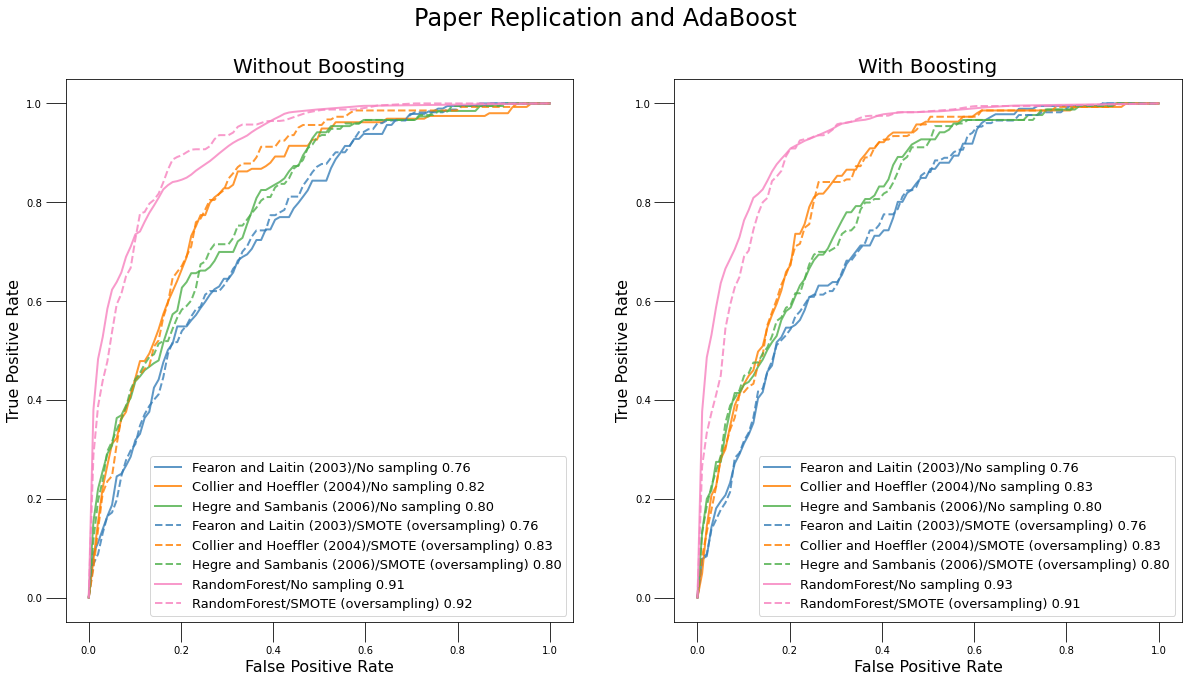

In [16]:
# Convert the df for each method into numpy array
X = [df_FearonLaitin.to_numpy(), df_CollierHoeffler.to_numpy(), df_HegreSambanis.to_numpy(), df.to_numpy()]

# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()

linestyle = ['-','--','-.']
# Name of the logistic regression methods
method_name = ['Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
sampling_methods=[None, SMOTE, NearMiss]

# Create a multiplot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
    
# Plot the 3 methods without sampling methods
for i in range(0,3):
    #The l2 penalization should give results similar to the Firth rare event 
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), None )
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[i]+'/'+ sampling_names[0]+' %.2f'%mean_auc, lw=2, alpha=.8)
    
# Plot the 3 methods with oversampling
for i in range(0,3):
    #The l2 penalization should give results similar to the Firth rare event 
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), SMOTE)   
    mean_auc = auc(mean_fpr,mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label=method_name[i]+'/'+sampling_names[1]+ ' %.2f'%mean_auc, lw=2, alpha=.8)
    
# # Plot the 3 methods with undersampling
# for i in range(0,3):
#     #The l2 penalization should give results similar to the Firth rare event 
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), NearMiss)   
#     mean_auc = auc(mean_fpr,mean_tpr)
#     ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='-.', label=method_name[i]+'/'+sampling_names[2]+ ' %.2f'%mean_auc, lw=2, alpha=.8)    
    
    
# Plot the 3 methods without sampling methods, with AdaBoost 
for i in range(0,3):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), None )
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[i]+'/'+sampling_names[0]+' %.2f'%mean_auc, lw=2, alpha=.8) 
    
# Plot the 3 methods with oversampling, and AdaBoost
for i in range(0,3):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), SMOTE )
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label=method_name[i]+'/'+sampling_names[1]+' %.2f'%mean_auc, lw=2, alpha=.8)    

#     # Plot the 3 methods with undersampling, and AdaBoost
# for i in range(0,3):
#     # 10-fold cross-validation logistic regression, with no penalties
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=1000, random_state=0), NearMiss )
#     # Calculate the auc score
#     mean_auc = auc(mean_fpr,mean_tpr)
#     # Plot and and auc score ine the legends, rounded up to 2 decimals
#     ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='-.', label=method_name[i]+'/'+sampling_names[2]+' %.2f'%mean_auc, lw=2, alpha=.8)
    
    
#random forest 
for i in range(0,2):
    # 10-fold cross-validation Random forests
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[3],y, RandomForestClassifier(random_state=42), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[3], ls=linestyle[i], label='RandomForest'+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation Random forests
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X[3],y, AdaBoostClassifier(RandomForestClassifier(random_state=42), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[3], ls=linestyle[i], label='RandomForest'+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)


fig.suptitle('Paper Replication and AdaBoost', fontsize=24)
# Set axis labels
# ax1.set(xlabel='False Positive Rate',ylabel='True Positive Rate', fontsize = 16)
# ax2.set(xlabel='False Positive Rate',ylabel='True Positive Rate',fontsize = 16)

ax1.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label

# Set titles
ax1.set_title('Without Boosting', fontsize = 20)
ax2.set_title('With Boosting', fontsize = 20)
ax1.tick_params(size=20)
ax2.tick_params(size=20)

#ax1.set_xticklabels
# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 13)
ax2.legend(loc=4, fontsize = 13)    
plt.show()

# Models with all features

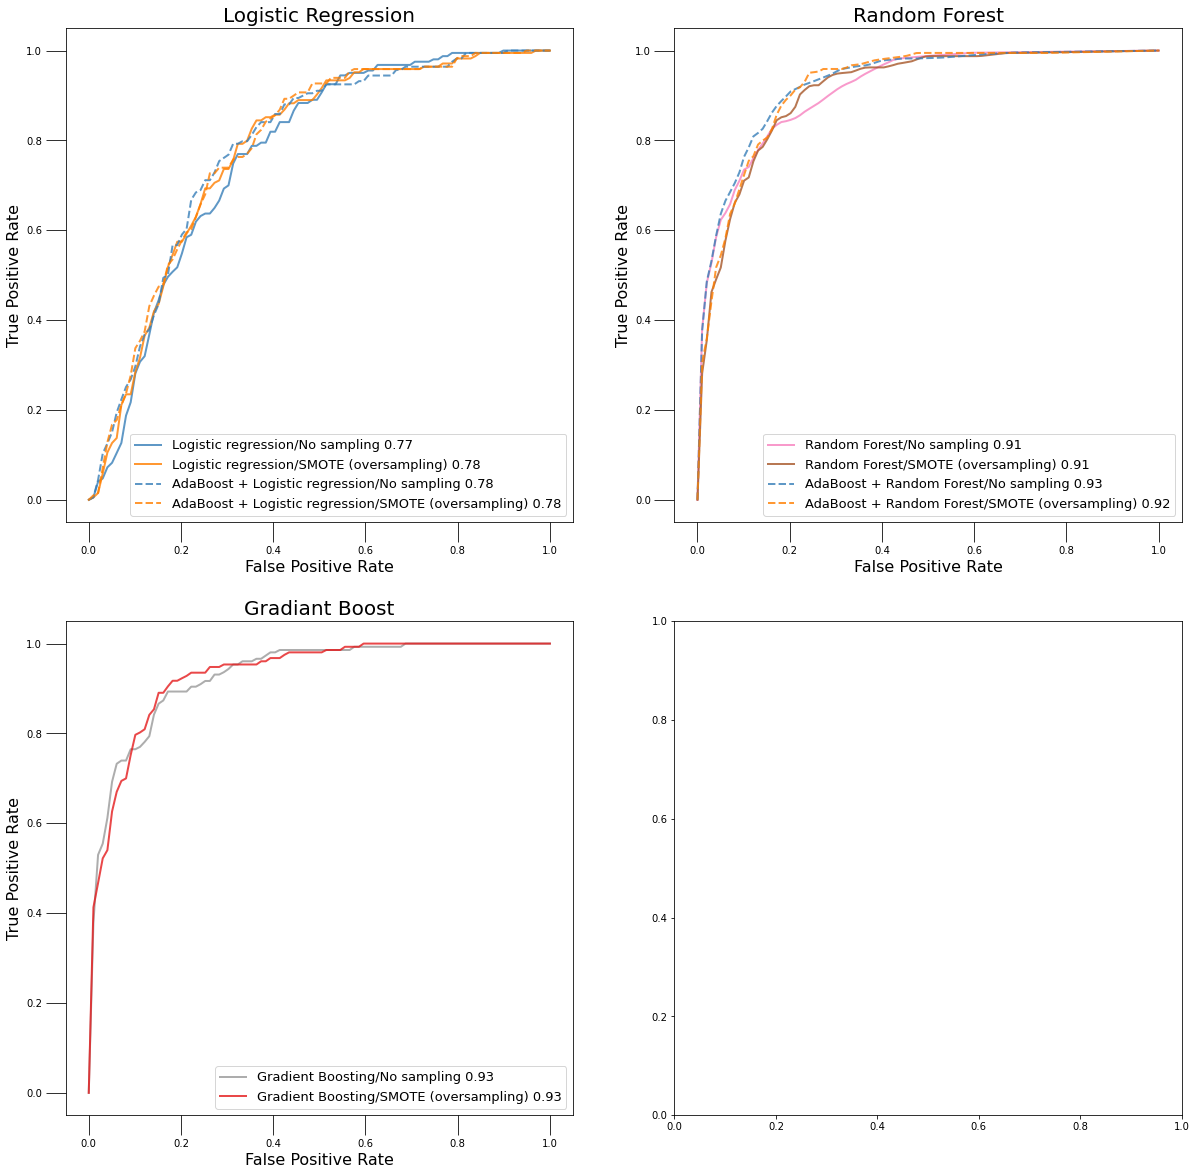

In [6]:
# Convert the df for each method into numpy array
X = df.to_numpy()
# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()
# Name of the logistic regression methods
method_name = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']

sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Create a multiplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,20))
    
# Plot the 2 methods with uncorrected Logits 
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 2 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

#random forest 
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, RandomForestClassifier(random_state=42), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i+3], label=method_name[1]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(RandomForestClassifier(random_state=42), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+ method_name[1] +'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

#gradient boosting
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, GradientBoostingClassifier(), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score ine the legends, rounded up to 2 decimals
    ax3.plot(mean_fpr, mean_tpr, color=color[i+6], label=method_name[2]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    
    
# Set axis labels
ax1.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax3.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax3.set_xlabel('False Positive Rate', fontsize = 16) # X label

# Set titles
ax1.set_title('Logistic Regression', fontsize = 20)
ax2.set_title('Random Forest', fontsize = 20)
ax3.set_title('Gradient Boost', fontsize = 20)

ax1.tick_params(size=20)
ax2.tick_params(size=20)
ax3.tick_params(size=20)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 13)
ax2.legend(loc=4, fontsize = 13)  
ax3.legend(loc=4, fontsize = 13)  
    
plt.show()

# With cost-sensitive methods

In [ ]:
# Convert the df for each method into numpy array
X = df.to_numpy()
# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()
# Name of the logistic regression methods
method_name = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']

sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Create a multiplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,20))
    
# Plot the 2 methods with uncorrected Logits 
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, LogisticRegression(random_state=42, penalty='none', max_iter=1000000, class_weight='balanced'), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=1000000, class_weight='balanced'), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost +'+method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
    
    
print('______________________')

#random forest 
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, RandomForestClassifier(random_state=42, class_weight='balanced'), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i+3], label=method_name[1]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost +'+method_name[1]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
print('______________________')
#gradient boosting
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, GradientBoostingClassifier(), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax3.plot(mean_fpr, mean_tpr, color=color[i+6], label=method_name[2]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
for i in range(0,2):
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(GradientBoostingClassifier(), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax3.plot(mean_fpr, mean_tpr, color=color[i+6], ls='--', label='AdaBoost +'+method_name[2]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    print(i)
    

# # Plot the 3 methods with over sampling
# for i in range(0,4):
#     #The l2 penalization should give results similar to the Firth rare event 
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y,'l2', LogisticRegression)   
#     mean_auc = auc(mean_fpr,mean_tpr)
#     ax2.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[i]+ ' %.2f'%mean_auc, lw=2, alpha=.8)

# Set axis labels
ax1.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax3.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax3.set_xlabel('False Positive Rate', fontsize = 16) # X label

# Set titles
ax1.set_title('Logistic Regression', fontsize = 20)
ax2.set_title('Random Forest', fontsize = 20)
ax3.set_title('Gradient Boost', fontsize = 20)

ax1.tick_params(size=20)
ax2.tick_params(size=20)
ax3.tick_params(size=20)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 13)
ax2.legend(loc=4, fontsize = 13)  
ax3.legend(loc=4, fontsize = 13)  
    
plt.show()

0
1


C:\Users\yasse\.conda\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yasse\.conda\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

0
1
2
______________________
0
1
0
1
______________________
0
1
0


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores

# KNN Classifier

No handles with labels found to put in legend.


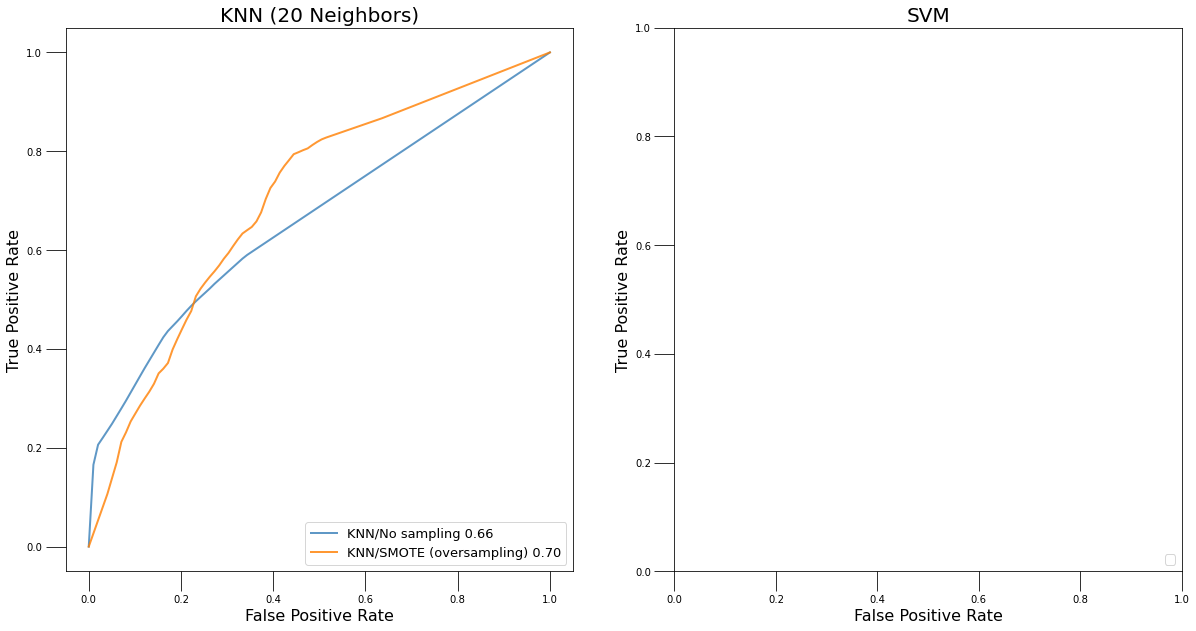

In [10]:
# Convert the df for each method into numpy array
X = df.to_numpy()
# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()
# Name of the logistic regression methodsmethod_name = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
sampling_methods=[None, SMOTE, NearMiss]

k_min = 1
k_max = 100
l = len(range(k_min,k_max))

neighbors = np.empty(l, dtype=object)
FPR = np.empty(l, dtype=object)
TPR = np.empty(l, dtype=object)
F1 = np.empty(l, dtype=object)
AUC = np.empty(l, dtype=object)

# Plot the 2 methods with uncorrected Logits 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

# for idx, j in enumerate(range(k_min, k_max)):
for i in range(0,2):
# 10-fold cross-validation logistic regression, 
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, KNeighborsClassifier(n_neighbors = 20), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label= method_name[3]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 2 methods with uncorrected Logits 
# for i in range(0,2):    
#     # 10-fold cross-validation logistic regression, with no penalties
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(KNeighborsClassifier(n_neighbors = neighbors), n_estimators=100, random_state=0), sampling_methods[i])
#     # Calculate the auc score
#     mean_auc = auc(mean_fpr,mean_tpr)
#     # Plot ROC and auc score in the legends, rounded up to 2 decimals
#     ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+method_name[3]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

c = [0.001, 0.01, 0.1, 1]
penalties = ['l1','l2']
loss = ['hinge', 'squared_hinge']

# for i in range(0,2):
# # 10-fold cross-validation logistic regression, 
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, SVC(probability = True,random_state = 42), sampling_methods[i]) #class_weight = None,
#     # Calculate the auc score
#     mean_auc = auc(mean_fpr,mean_tpr)
#     # Plot ROC and auc score in the legends, rounded up to 2 decimals
#     ax2.plot(mean_fpr, mean_tpr, color=color[i], label= method_name[4]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# #Plot the 2 methods with uncorrected Logits 
# for i in range(0,2):    
#     # 10-fold cross-validation SVC, with no penalties
#     mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(SVC(probability = True,random_state = 42), n_estimators=100, random_state=0), sampling_methods[i])
#     # Calculate the auc score
#     mean_auc = auc(mean_fpr,mean_tpr)
#     # Plot ROC and auc score in the legends, rounded up to 2 decimals
#     ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+method_name[4]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

# Set axis labels
ax1.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label
# ax3.set_ylabel('True Positive Rate', fontsize = 16) # Y label
# ax3.set_xlabel('False Positive Rate', fontsize = 16) # X label

# Set titles
ax1.set_title('KNN (20 Neighbors)', fontsize = 20)
ax2.set_title('SVM', fontsize = 20)
# ax3.set_title('Gradient Boost', fontsize = 20)

ax1.tick_params(size=20)
ax2.tick_params(size=20)
# ax3.tick_params(size=20)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 13)
ax2.legend(loc=4, fontsize = 13)  
# ax3.legend(loc=4, fontsize = 13)  
    
plt.show()

In [ ]:
fig, ax2 = plt.subplots(1, 1,figsize=(10,10))
for i in range(0,2):
# 10-fold cross-validation logistic regression, 
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, SVC(probability = True,random_state = 42), sampling_methods[i]) #class_weight = None,
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], label= method_name[4]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
#Plot the 2 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation SVC, with no penalties
    mean_fpr,mean_tpr = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(SVC(probability = True,random_state = 42), n_estimators=100, random_state=0), sampling_methods[i])
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+method_name[4]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label
# Set titles
ax2.set_title('SVM', fontsize = 20)
# Show the legend (loc 4 is bottom-right)
ax2.legend(loc=4, fontsize = 13)  
    
plt.show()

### Discussion
Comparing to the figure in the paper, we can say that these two figures are similar and follows the same trends.
The uncorrected logits figure is really similar and the AUC score are almost the same (except for the Fearon and Latin (2003) score who's score is 0.76 instead of 0.77.
The Penalized Logits results are also pretty similar and the curves have less disctance between them compared to the Uncorrected Logits, like in the paper. Expect for the Colier and Hoeffler(2004). The AUC score is 0.74 instead of 0.77 and the curve should cross multiple times the Fearon and Laitin (2003) curve instead always being lower.   

In [39]:
One explanation could be that the dataset used in Colier and Hoeffler(2004) contains way less rare events than the two other methods, therefore the L2 penalization that we used to approximate Firht penalization could react differently to a datasets having less rare events.

30328
8606
61477
